🔹 Using Device: cpu
📌 Epoch 1/10: Loss = 0.6779, Train Accuracy = 32.48%, Validation Accuracy = 32.88%
📌 Epoch 2/10: Loss = 0.5938, Train Accuracy = 48.23%, Validation Accuracy = 42.00%
📌 Epoch 3/10: Loss = 0.5460, Train Accuracy = 55.88%, Validation Accuracy = 51.06%
📌 Epoch 4/10: Loss = 0.5180, Train Accuracy = 59.23%, Validation Accuracy = 52.75%
📌 Epoch 5/10: Loss = 0.4932, Train Accuracy = 62.67%, Validation Accuracy = 53.88%
📌 Epoch 6/10: Loss = 0.4733, Train Accuracy = 65.48%, Validation Accuracy = 56.06%
📌 Epoch 7/10: Loss = 0.4625, Train Accuracy = 67.42%, Validation Accuracy = 55.75%
📌 Epoch 8/10: Loss = 0.4494, Train Accuracy = 68.00%, Validation Accuracy = 58.75%
📌 Epoch 9/10: Loss = 0.4334, Train Accuracy = 70.60%, Validation Accuracy = 59.25%
📌 Epoch 10/10: Loss = 0.4143, Train Accuracy = 72.27%, Validation Accuracy = 59.94%
✅ Student Model Trained & Saved!
✅ Teacher Model Pruned!
📊 Student Model Evaluation Results:
✅ Accuracy: 65.38%
✅ F1 Score: 63.51%

📊 Evaluation Summ

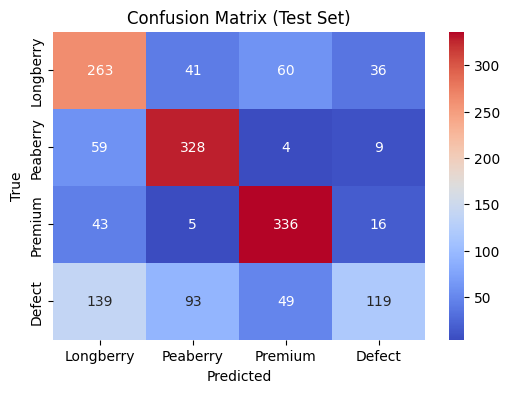

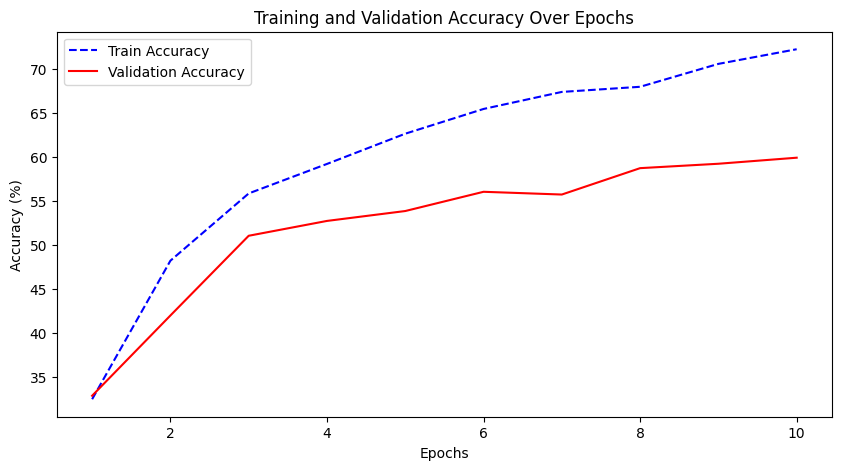

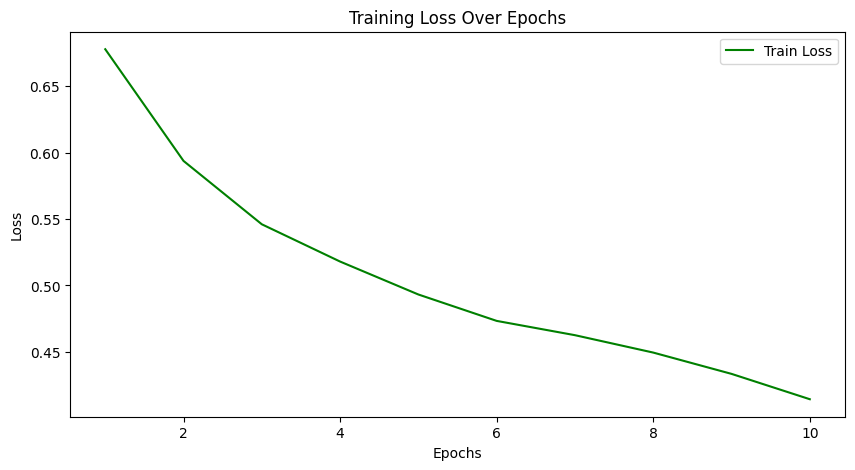

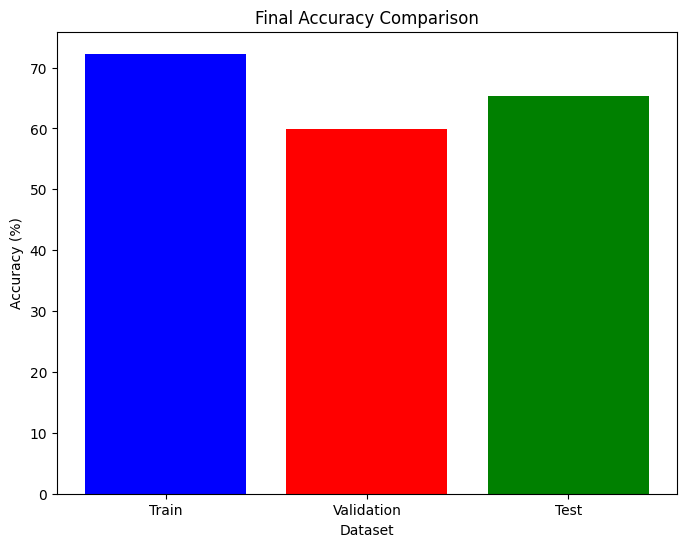

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from termcolor import colored
from vit_pytorch import SimpleViT

# Define the Teacher Model (Vision Transformer)
class TeacherModel(nn.Module):
    def __init__(self):
        super(TeacherModel, self).__init__()
        self.vit = SimpleViT(
            image_size=32,
            patch_size=4,
            num_classes=4,
            dim=128,
            depth=2,
            heads=4,
            mlp_dim=256
        )
    
    def forward(self, x):
        return self.vit(x)

# Define the Student Model (Smaller Sparse CNN)
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 classes
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Define Dataset & DataLoader
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root="C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root="C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

val_dataset = datasets.ImageFolder(root="C:\\Users\\user\\Desktop\\CSC YEAR 2\\SEM 2\\MACHINE LEARNING\\dataset3\\USK-Coffee\\val", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(colored(f"🔹 Using Device: {device}", "yellow"))

teacher_model = TeacherModel().to(device)
student_model = StudentModel().to(device)

# Define Loss, Optimizer, and KD Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.001)

def kd_loss(student_outputs, teacher_outputs, labels, alpha=0.5, temperature=3.0):
    soft_targets = F.softmax(teacher_outputs / temperature, dim=1)
    soft_loss = F.kl_div(F.log_softmax(student_outputs / temperature, dim=1), soft_targets, reduction='batchmean')
    hard_loss = F.cross_entropy(student_outputs, labels)
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Train Student Model using Knowledge Distillation
def train_student(student, teacher, train_loader, val_loader, criterion, optimizer, epochs=10):
    teacher.eval()
    student.train()

    train_losses, train_accuracies, val_accuracies = [], [], []
    
    for epoch in range(epochs):
        running_loss, correct_train, total_train = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.no_grad():
                teacher_outputs = teacher(images)
            
            student_outputs = student(images)
            loss = kd_loss(student_outputs, teacher_outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted_train = torch.max(student_outputs, 1)
            correct_train += (predicted_train == labels).sum().item()
            total_train += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc_train = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc_train)
        
        # Evaluate on validation set
        student.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images_val, labels_val in val_loader:
                images_val, labels_val = images_val.to(device), labels_val.to(device)
                outputs_val = student(images_val)
                _, predicted_val = torch.max(outputs_val, 1)
                correct_val += (predicted_val == labels_val).sum().item()
                total_val += labels_val.size(0)
        epoch_acc_val = 100 * correct_val / total_val
        val_accuracies.append(epoch_acc_val)
        
        student.train()
        
        print(colored(f"📌 Epoch {epoch+1}/{epochs}: Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_acc_train:.2f}%, Validation Accuracy = {epoch_acc_val:.2f}%", "green"))

    torch.save(student.state_dict(), "student_model.pth")
    print(colored("✅ Student Model Trained & Saved!", "blue"))
    return train_losses, train_accuracies, val_accuracies

train_losses, train_accuracies, val_accuracies = train_student(student_model, teacher_model, train_loader, val_loader, criterion, optimizer, epochs=10)

# Prune the Teacher Model
def prune_teacher(model, amount=0.5):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')
    print(colored("✅ Teacher Model Pruned!", "cyan"))
    torch.save(model.state_dict(), "pruned_teacher_model.pth")

prune_teacher(teacher_model, amount=0.5)

# Evaluate the Student Model
def evaluate_student(model, test_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds) * 100
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    
    print(colored(f"📊 Student Model Evaluation Results:", "cyan"))
    print(colored(f"✅ Accuracy: {accuracy:.2f}%", "yellow"))
    print(colored(f"✅ F1 Score: {f1:.2f}%", "yellow"))
    
    return accuracy, f1, all_preds, all_labels

test_accuracy, test_f1, test_preds, test_labels = evaluate_student(student_model, test_loader)

# Tabulate Results
table = PrettyTable(["Dataset", "Accuracy", "F1 Score", "Learning Rate"])
table.add_row(["Test Set", test_accuracy, test_f1, "0.001"])
print(colored("\n📊 Evaluation Summary:", "cyan"))
print(table)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Longberry", "Peaberry", "Premium", "Defect"], yticklabels=["Longberry", "Peaberry", "Premium", "Defect"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_confusion_matrix(test_labels, test_preds, "Confusion Matrix (Test Set)")

# Plot Training Metrics
def plot_metrics(train_acc, val_acc):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label="Train Accuracy", color="blue", linestyle="--")
    plt.plot(epochs, val_acc, label="Validation Accuracy", color="red", linestyle="-")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy Over Epochs")
    plt.legend()
    plt.show()

plot_metrics(train_accuracies, val_accuracies)

# Plot Training Loss
def plot_loss(train_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label="Train Loss", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()

plot_loss(train_losses)

# Bar Graph for Final Results
def plot_final_results(train_acc, val_acc, test_acc):
    plt.figure(figsize=(8, 6))
    plt.bar(['Train', 'Validation', 'Test'], [train_acc[-1], val_acc[-1], test_acc], color=['blue', 'red', 'green'])
    plt.title('Final Accuracy Comparison')
    plt.xlabel('Dataset')
    plt.ylabel('Accuracy (%)')
    plt.show()

plot_final_results(train_accuracies, val_accuracies, test_accuracy)
